It is well known that the distribution of p-values of a hypothesis test under the null hypothesis is uniform. We're interested in exploring the distribution of p-values in a hypothesis test when the alternative hypothesis is true. 

Apart from an interesting exercise, this information is useful when assessing the results of repeated measures hypothesis testings. That is, when we have one hypothesis that we test more than once for significance. It is expected that as the numer of realizations of the test statistic increases, some of them will show significant results, so one must always be careful when testing hypotheses repeatedly. If they follow a uniform distribution somewhat closely it's evidence in favor of the null. If they do not, assuming we know the distributions under the null and the alternative, we can analyze the distribution with a broader set of tools



# Case 1: Sample mean

We will now derive the distribution of P-values assuming the alternative hypothesis is true.

Given samples from some population with known variance $\sigma$, we're interested in the p-values of the following hypothesis:

  \begin{equation}
    \begin{cases}
      H_0 : \mu = 0 \\
      H_1 : \mu > 0
    \end{cases}
  \end{equation}

This is a right-tail hypothesis which, given a realization of the sample mean with sample size $n$, has the statistic $T=\sqrt{n}\bar{x}/\sigma$ under the null. The p-value is a one-to-one function of $T$,  $P=1-\Phi(T)$ where $\Phi(T)$ is the cumulative standard normal. 

Assuming the actual mean is $\mu$ but the variance stays the same, define $\delta = \mu/\sigma$, and derive a distribution of $P$ via the following auxiliary function, keeping in mind that $T$ has variance one and mean $\delta\sqrt{n}$:

$$
G(T) =\textbf{P}(T \leq \Phi^{-1}(1-p)) = \Phi_{\delta\sqrt{n}}(\Phi(1-p))
$$
Then

$$
g(p) := \frac{dG}{dp} = \frac{\phi(\Phi^{-1}(1-p)-\delta\sqrt{n})}{\phi(\Phi^{-1}(1-p))}
$$

this $g(p)$ is the distribution of the p-values given the value of $\delta$ and $n$. 

Notice how $g$ is uniform when $\mu=0$, as expected. 

This is all taken from a great paper: 

H. M. James Hung, Robert T. O'Neill, Peter Bauer and Karl Kohne (1997). The Behavior of the P-Value When the Alternative Hypothesis is True. Biometrics, 53(1), 11–22. doi:10.2307/2533093

An extension of this for other statistics and use cases can be found in https://arxiv.org/pdf/2012.01697.pdf

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t as T
import scipy
import seaborn as sns

In [83]:
class Population:
  def __init__(self, mu, sigma, distribution):
    """
    Takes the expected mean, standard deviation, 
    and distribution to sample from.
    Distribution can be "normal" or "uniform", or "chi2" with 
    two degrees of freedom.
    """
    self.mu = mu
    self.sigma = sigma
    self.dist = distribution

  def sample(self, sample_size:int): 
    """
    Returns numpy array of samples 
    from the distribution of size sample_size 
    """
    if self.dist == "normal":
      self.skew = 0
      self.kurtosis = 3
      return np.random.normal(loc= self.mu, scale = self.sigma,  size = sample_size)
    if self.dist == "uniform":
      a = self.mu - (np.sqrt(12)/2)*self.sigma
      b = self.mu + (np.sqrt(12)/2)*self.sigma
      self.skew = 0
      self.kurtosis = 9/5
      return np.random.uniform(low = a, high = b, size = sample_size)
    if self.dist == "chi2":
      #self.mu = 2
      #self.sigma = 2
      self.skew = 2
      self.kurtosis = 9
      return (np.random.chisquare(df=2, size = sample_size)-2)*(self.sigma/2)+self.mu

In [3]:
def g_dist(p,delta, n):
  Zp = norm.ppf(1-p)
  return norm.pdf(Zp-delta*np.sqrt(n), loc=0, scale =1)/norm.pdf(Zp)

In [27]:
population = Population(1, 4, "normal")

In [28]:
np.random.seed(350) #we'll set a seed to be able to reproduce the results
print(f'True population mean: {population.mu}')
print(f'True population variance: {population.sigma}, this one we´ll count as given')

True population mean: 1
True population variance: 4, this one we´ll count as given


[]

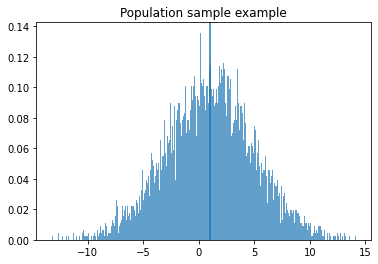

In [29]:
population_samp = population.sample(5000)
plt.hist(population_samp,  density = True, alpha = 0.7, bins=300)
plt.title("Population sample example")
plt.axvline(x=population.mu)
plt.plot()

In [30]:
# Now, given a sample, we want to calculate the T statistic and the p-value associated to it:
sample_size = 50  #set sample size

sample = population.sample(sample_size)  # generate sample
sample_T = np.sqrt(sample_size)*np.mean(sample)/population.sigma  # compute statistic
sample_pval = 1 - norm.cdf(sample_T) # compute p_value

print(f'In this example, there´s a sample mean of {np.round(np.mean(sample),4)}, with an associated statistic of {np.round(sample_T, 4)} and a p-value of {np.round(sample_pval,4)}')

In this example, there´s a sample mean of 0.4625, with an associated statistic of 0.8176 and a p-value of 0.2068


In [31]:
# let's get this into a function with a loop for easy access:
def sample_pvals(num_pvals, sample_size = 100, population = population):
  PV = []
  sampleT =[]
  for i in range(num_pvals):
    sample = population.sample(sample_size)
    sample_T = np.mean(sample)/(population.sigma/np.sqrt(sample_size))
    sample_pval = T.sf(sample_T, df=sample_size-1)
    sampleT.append(sample_T)
    PV.append(sample_pval)
  return np.array(PV), np.array(sampleT)

In [32]:
pvals, statistics = sample_pvals(5000, sample_size = sample_size)

[]

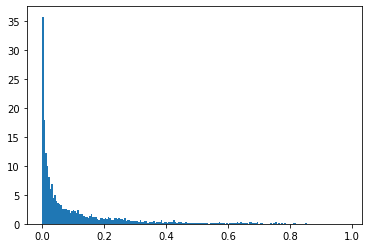

In [33]:
# Let's plot the distribution of the p-values
plt.hist(pvals, density = True, bins=200)
plt.plot()

[]

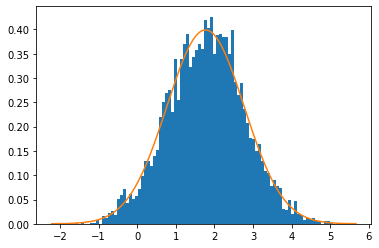

In [34]:
# We'll do a sanity check to see if the test statistics are being distributed normally
z_axis = np.linspace(np.min(statistics)-0.05,np.max(statistics)+0.05, num= 5000)
z_val_dist = [norm.pdf(z, loc = np.sqrt(sample_size)/population.sigma, scale = 1) for z in z_axis]
plt.hist(statistics, density = True, bins=100)
plt.plot(z_axis, z_val_dist)
plt.plot()

In [107]:
# Let's overlay the histogram with the expected distribution g(p):
p_axis = np.linspace(0.0025,np.max(pvals)+0.05, num= 100)
p_val_dist = [g_dist(p, delta = population.mu/population.sigma, n = 100) for p in p_axis]

[]

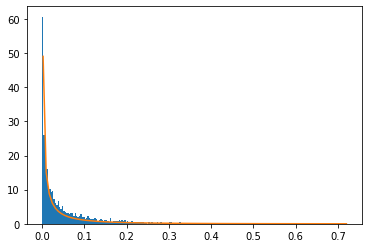

In [108]:
plt.hist(pvals, density = True, bins=200)
plt.plot(p_axis, p_val_dist)
plt.plot()

# Case 2: Sample mean with estimated variance

Now that we know the expected distribution of the p-values, let's see what happens to the empirical distribution when we use an estimated variance from the sample variance:

In [14]:
population = Population(1, 4, "normal")
sample_size = 20

In [15]:
def sample_pvals_estimatedSD(num_pvals, sample_size = 100):
  PV = []
  sampleT =[]
  for i in range(num_pvals):
    sample = population.sample(sample_size)
    sample_T = np.mean(sample)/(np.std(sample)/np.sqrt(sample_size))
    sample_pval = T.sf(sample_T, df=sample_size-2)
    sampleT.append(sample_T)
    PV.append(sample_pval)
  return np.array(PV), np.array(sampleT)

In [16]:
pvals, statistics = sample_pvals_estimatedSD(5000, sample_size = sample_size)

[]

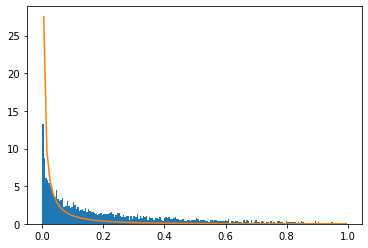

In [17]:
p_axis = np.linspace(0.005,np.max(pvals)+0.05, num= 100)
p_val_dist = [g_dist(p, delta = population.mu/population.sigma, n = 100) for p in p_axis]
plt.hist(pvals, density = True, bins=200)
plt.plot(p_axis, p_val_dist)
plt.plot()

We can see the empirical distribution tends to reject less on these low sample sizes than what would be expected given that we knew the variance. 

This highlights the importance of sample size.

## Aside: Sample size and eternal rejection of the null

This section is dedicated to highlighting the fact that a rejection of the null hypothesis does not signify a meaningful association between variables, particularly and specially in the large-n case.

A lot of moden applications of data science use large amounts of data. This is good, on the one hand, because usually the assumptions of asymptotic normality of most statistics is much closer to being fulfilled. On the other, it allows us to reject lack of association in many instances where there is no meaning to that difference; i.e.: the effect size is small. This problem stems from a misinterpretation of the p-value: it only measures the probability of observing a result as the one sampled or more extreme, under the null hypothesis, and it does not say anything about the importance of such difference, let alone the 'truth' of that difference.

Recalling $P = 1- \Phi(T)$, and $T = \sqrt{n}\bar{x}/\sigma$, assuming a rejection level of $\alpha$, we would reject at said level for the following sample means:

\begin{align}
\alpha \geq & \> P = 1 - \Phi(\sqrt{n}\bar{x}/\sigma) \\
\Phi(\sqrt{n}\bar{x}/\sigma) \geq & \> 1- \alpha \\
\bar{x} \geq & \> \Phi^{-1}(1- \alpha)\> \frac{\sigma}{\sqrt{n}} \propto n^{-1/2}
\end{align}

Recall the null mean parameter is zero, so we are also seing the distance between the sample mean and the hypothesized mean. 


In [110]:
means = []
colors = []
X = []
levels = [{'alpha':0.05, 'color':'red'},{'alpha':0.01, 'color':'blue'},{'alpha':0.001, 'color':'green'}]
samp_n = np.linspace(100,100000, num= 60)
for case in levels:
  for n in samp_n:
    reject = norm.ppf(1-case['alpha'])
    means.append(reject/np.sqrt(n))
    colors.append(case['color'])
    X.append(n)

[]

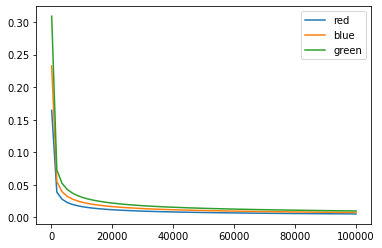

In [112]:
sns.lineplot(x=X, y=means, hue=colors)
plt.plot()

We can see here how, as a function of $n$, the difference required to reject the null hypothesis gets smaller and smaller, with the test being able to detect even the slightest differences from the null mean.